In [34]:
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime,timedelta
import random
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.stem import PorterStemmer
import gensim.downloader
from collections import defaultdict

In [2]:
user_index = json.load(open("../data/user_index.json",'r'))
commitment_index = json.load(open("../data/commitment_index.json",'r'))

In [3]:
max_user_id = max([int(i) for i in user_index.keys()])

In [4]:
for k,v in tqdm(user_index.items()):
    user_index[k]['date'] = datetime.strptime(v['date'], '%d %b %Y')

  0%|          | 0/521632 [00:00<?, ?it/s]

In [5]:
id_for_1_jan_2023 = 722621
for k,v in tqdm(user_index.items()):
    if int(k)<id_for_1_jan_2023 and v['date'].year == 2023:
        user_index[k]['date'] = None

  0%|          | 0/521632 [00:00<?, ?it/s]

In [6]:
last_date = user_index['1']['date']
for i in range(1, max_user_id+1):
    if str(i) in user_index.keys():
        if user_index[str(i)]['date'] == None:
            user_index[str(i)]['date'] = last_date
        else:
            last_date = user_index[str(i)]['date']

In [7]:
for k,v in tqdm(commitment_index.items()):
    commitment_index[k]['start_date'] = datetime.strptime(v['start_date'], '%B %d, %Y')
    commitment_index[k]['end_date'] = datetime.strptime(v['end_date'], '%B %d, %Y')

  0%|          | 0/319928 [00:00<?, ?it/s]

In [8]:
for k,v in tqdm(commitment_index.items()):
    if v['start_date'].year < 2007:
        deta = v['end_date'] - v['start_date']
        commitment_index[k]['start_date'] = user_index[str(v['user_id'])]['date']
        commitment_index[k]['end_date'] = commitment_index[k]['start_date'] + deta

  0%|          | 0/319928 [00:00<?, ?it/s]

Extract data

In [16]:
w2v = gensim.downloader.load('word2vec-google-news-300')

In [9]:
len(commitment_index)

319928

In [10]:
ps = PorterStemmer()

In [11]:
def preprocess_title(title):
    title = title.lower()
    title = title.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(title)
    tokens = [ps.stem(i) for i in tokens]
    return tokens

In [35]:
term_dict = {
    "weight":["weight","diet","fat", "pound", "kg", "calories"],
    "eat":["eat","chocolate", "water", "food", "sugar", "softdrinks", "candy", "desserts", "veggies","gluten", "lactose", "snacking", "coffee","beverage"],
    "exercise":["exercise","run", "walk","race", "cycling","work-out","workout", "bicyclng"],
    "smoking":["smoking"],
    "alcohol":['alcohol','drink'],
    "sleep":["sleep","bed","wake"],
    "read":["read","book"],
    "study":["study","exam","diploma", "phd", "assignment", "math","gmat",'homework', 'gre', 'sat'],
    "write":["write","draft", "screenplay","scripts"],
    "mastrubate":["mastrubate","mastrubation","porn","masturbation",'nofap','fap'],
    "meditate":["meditate","journal"],
    "money":["money","finance","saving", "expense", "spending"],
    "nail":["nail"],
    "client":["client","job","business",'network'],
    "procrastinating":["procrastinating","procrastinate","procrastination"],
    "clean":["clean"],
    "internet":["internet", "social media", "electronics",'tv','phone']
}

In [36]:
in_term_similarity = defaultdict(list)
for k, v in term_dict.items():
    res = list(combinations(v, 2))
    for i in res:
        if i[0] in w2v and i[1] in w2v:
            in_term_similarity[k].append(w2v.similarity(i[0],i[1]))

In [40]:
in_sim_v = []
for k,v in in_term_similarity.items():
    in_sim_v.append([k, min(v),max(v),np.mean(v),np.std(v)])
    
pd.DataFrame(in_sim_v, columns=['class','min','max','mean','std']).sort_values("mean", ascending=False)

,class,min,max,mean,std
12,procrastinating,0.660257,0.710366,0.685926,0.020475
3,alcohol,0.628700,0.628700,0.628700,0.000000
5,read,0.389365,0.389365,0.389365,0.000000
8,mastrubate,0.299516,0.438214,0.377012,0.057784
4,sleep,0.239753,0.577686,0.360037,0.154186
0,weight,0.142086,0.532715,0.347111,0.141185
1,eat,0.060871,0.637569,0.337705,0.112322
7,write,0.110299,0.549825,0.262716,0.151661
10,money,0.068886,0.355374,0.243393,0.084542
13,internet,0.150946,0.396543,0.241712,0.094719


In [41]:
off_term_similarity = defaultdict(list)
for k1,v1 in term_dict.items():
    for k2,v2 in term_dict.items():
        if k1!=k2:
            for a in v1:
                for b in v2:
                    if a in w2v and b in w2v:
                        off_term_similarity[(k1,k2)].append(w2v.similarity(a,b))

In [44]:
off_sim_v = []
for k,v in off_term_similarity.items():
    off_sim_v.append([k, min(v),max(v),np.mean(v),np.std(v)])
    
pd.DataFrame(off_sim_v, columns=['class','min','max','mean','std']).sort_values("mean", ascending=False).head(20)

,class,min,max,mean,std
67,"(alcohol, smoking)",0.364885,0.444901,0.404893,0.040008
51,"(smoking, alcohol)",0.364885,0.444901,0.404893,0.040008
19,"(eat, alcohol)",0.125515,0.581995,0.321292,0.103113
65,"(alcohol, eat)",0.125515,0.581995,0.321292,0.103113
105,"(read, meditate)",0.190730,0.421407,0.301955,0.082809
166,"(meditate, read)",0.190730,0.421407,0.301955,0.082809
103,"(read, write)",0.145222,0.630653,0.299361,0.155253
134,"(write, read)",0.145222,0.630653,0.299361,0.155253
234,"(procrastinating, meditate)",0.146607,0.369185,0.224935,0.073468
173,"(meditate, procrastinating)",0.146607,0.369185,0.224935,0.073468


In [28]:
len(off_term_similarity)

4436

In [29]:
min(in_term_similarity),max(in_term_similarity),np.mean(in_term_similarity),np.std(in_term_similarity)

(-0.10160349, 0.71036583, 0.29306364, 0.14897755)

In [30]:
min(off_term_similarity),max(off_term_similarity),np.mean(off_term_similarity),np.std(off_term_similarity)

(-0.11875986, 0.63065284, 0.102334395, 0.09026532)

(array([ 3.,  7., 17., 38., 41., 38., 31., 12.,  6.,  4.]),
 array([-0.10160349, -0.02040656,  0.06079037,  0.14198731,  0.22318424,
         0.30438116,  0.3855781 ,  0.46677503,  0.54797196,  0.62916893,
         0.71036583]),
 <BarContainer object of 10 artists>)

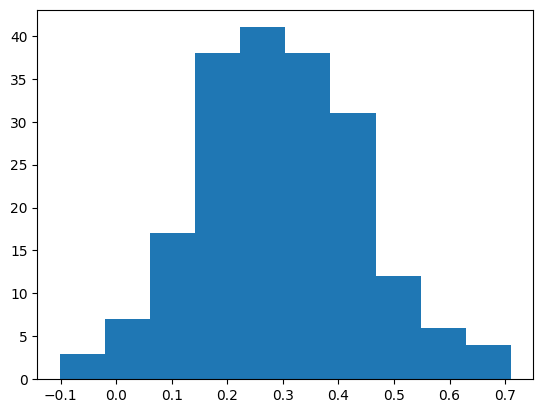

In [31]:
plt.hist(in_term_similarity)

(array([  54.,  830., 1796., 1074.,  400.,  154.,   78.,   40.,    6.,
           4.]),
 array([-0.11875986, -0.04381859,  0.03112268,  0.10606395,  0.18100522,
         0.25594649,  0.33088776,  0.40582904,  0.48077029,  0.55571157,
         0.63065284]),
 <BarContainer object of 10 artists>)

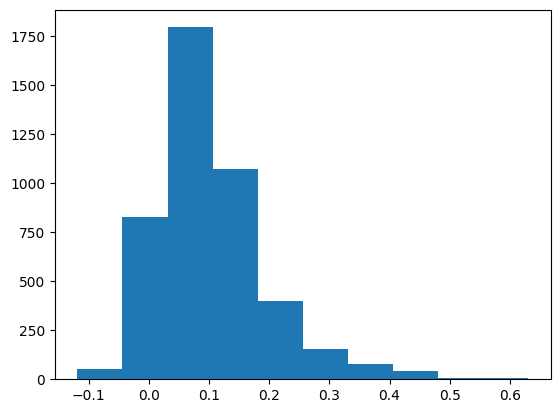

In [32]:
plt.hist(off_term_similarity)

In [33]:
off_term_similarity = []
for k1,v1 in term_dict.items():
    for k2,v2 in term_dict.items():
        if k1!=k2:
            for a in v1:
                for b in v2:
                    if a in w2v and b in w2v:
                        if w2v.similarity(a,b)>=0.4:
                            print(a,b)
                        

diet eat
diet gluten
diet lactose
diet snacking
fat eat
calories eat
calories veggies
calories snacking
eat diet
eat fat
eat calories
veggies calories
gluten diet
lactose diet
snacking diet
snacking calories
eat drink
chocolate drink
food drink
softdrinks drink
snacking drink
coffee drink
beverage drink
eat sleep
smoking alcohol
drink eat
drink chocolate
drink food
drink softdrinks
drink snacking
drink coffee
drink beverage
alcohol smoking
sleep eat
sleep meditate
read write
book screenplay
book journal
study journal
assignment job
homework procrastinating
homework procrastinate
write read
screenplay book
porn internet
meditate sleep
journal book
journal study
job assignment
network internet
procrastinating homework
procrastinate homework
internet porn
internet network


In [39]:
count_dict = {k:[] for k in term_dict.keys()}

In [42]:
for k,v in tqdm(commitment_index.items()):
    pre_title = preprocess_title(v['title'])
    for t,rt in term_dict.items():
        for ct in rt:
            if ct in pre_title:
                count_dict[t].append(k)

  0%|          | 0/319928 [00:00<?, ?it/s]

In [43]:
for k,v in count_dict.items():
    print(f"{k} {len(v)}")

weight 88757
eat 12072
exercise 65761
smoking 8509
alcohol 4872
sleep 5820
read 7972
study 9104
write 5987
mastrubate 1926
meditate 5234
money 5100
nail 424
client 2866
procrastinating 1143
clean 1354
internet 1301


In [44]:
len(set([j for v in count_dict.values() for j in v]))

217372

In [45]:
len(set([j for v in count_dict.values() for j in v]))/len(commitment_index)

0.6794403740841689

In [46]:
for k,v in count_dict.items():
    print("-"*100)
    print(k)
    for j in random.sample(v,min(5,len(v))):
        print(commitment_index[j]['title'])

----------------------------------------------------------------------------------------------------
weight
Lose Weight
Lose Weight
Lose Weight
Lose Weight
Lose Weight
----------------------------------------------------------------------------------------------------
eat
No Eating Fast Food on Break
FOR REAL no snacking
Give up chocolate
Stop eating chocolate and cookies a...
Eating healthy...no sugar
----------------------------------------------------------------------------------------------------
exercise
Exercise Regularly
Exercise Regularly
Exercise Regularly
Exercise Regularly
Exercise Regularly
----------------------------------------------------------------------------------------------------
smoking
Quit Smoking
Quit Smoking
Quit Smoking
Quit Smoking
Quit Smoking
----------------------------------------------------------------------------------------------------
alcohol
No drinking
Stop Drinking Alcohol
no alcohol or tobacco till wake up ...
Drink 8 Cups of Water 5 days a We

In [47]:
res = list(combinations(count_dict.keys(), 2))
total_intersection_count = 0
for i in res:
    intersection_count = set.intersection(*[set(count_dict[j]) for j in i])
    total_intersection_count+=len(intersection_count)
    if len(intersection_count)>0:
        print("-"*50)
        print(f"{i} {len(intersection_count)}")
        for s in random.sample(list(intersection_count),min(5,len(intersection_count))):
            print(commitment_index[s]['title'])

--------------------------------------------------
('weight', 'eat') 341
removing sugar from diet
Eat no more than 1,700 calories and...
Gain weight without eating meat
Eat Healthier to lose weight
Diet & Healthy Eating
--------------------------------------------------
('weight', 'exercise') 260
Lose weight and exercise
Lose weight and Exercise More
Exercise regularly and lose weight....
Workout and Stick to my Strict Diet...
Exercise daily and lose weight by f...
--------------------------------------------------
('weight', 'smoking') 6
LOSE WEIGHT AND QUIT SMOKING
Weight loss and Quit Smoking
quit smoking & lose weight
quit smoking & lose weight
quit smoking and reach my weight go...
--------------------------------------------------
('weight', 'alcohol') 61
No Drinking until 170 pounds
Avoid Drinking Calories
Don't drink calories
Paleo Diet & Alcohol Free 5days/Wee...
Drink only 3 diet cokes during a we...
--------------------------------------------------
('weight', 'sleep') 7
los

--------------------------------------------------
('smoking', 'study') 1
Quit smoking until the end of exams...
--------------------------------------------------
('smoking', 'mastrubate') 3
stop masturbating and smoking pot e...
No smoking, fapping, drinking(accep...
No smoke no masturbate
--------------------------------------------------
('smoking', 'money') 2
save money and quit smoking
quit smoking and save money
--------------------------------------------------
('smoking', 'clean') 1
Eat Clean, Stop Smoking and Exercis...
--------------------------------------------------
('alcohol', 'sleep') 9
Drink water when waking up
Drink water on waking up
decrease eating and drinking in bed...
30 sleeps without alcohol.
decrease eating and drinking in bed...
--------------------------------------------------
('alcohol', 'study') 3
Drink 2L of water and 2 cups of gre...
no alcohol until the last exam
No drinking til exam *rules apply
--------------------------------------------------
('al

In [48]:
total_intersection_count

4993

In [49]:
res = list(combinations(count_dict.keys(), 3))
total_intersection_count = 0
for i in res:
    intersection_count = set.intersection(*[set(count_dict[j]) for j in i])
    total_intersection_count+=len(intersection_count)
    if len(intersection_count)>0:
        print("-"*50)
        print(f"{i} {len(intersection_count)}")
        for s in random.sample(list(intersection_count),min(5,len(intersection_count))):
            print(commitment_index[s]['title'])

--------------------------------------------------
('weight', 'eat', 'exercise') 10
Run regularly and eat 1400 calories...
Loose weight (exercise and eat ligh...
lose weight, eat healthy, exercise,...
Lose weight, eat healthy, exercise ...
Lose weight, exercise more and eat ...
--------------------------------------------------
('weight', 'eat', 'alcohol') 7
Diary my food, drink, and weight fo...
I will not drink diet soda, eat dee...
Diary my food, drink, and weight fo...
Drink my weight in ounces of water ...
Drink More Water / Limit Diet soda
--------------------------------------------------
('weight', 'eat', 'clean') 5
Clean eating for health and weight ...
Eat Clean and lost weight.
Lose weight and eat clean
Lose weight, Eat clean, get definit...
stick to diet and eat clean
--------------------------------------------------
('weight', 'exercise', 'sleep') 2
Sleep, Diet, and Exercise
lose weight, exercise, better sleep...
--------------------------------------------------
('weight

In [50]:
total_intersection_count

113

In [51]:
# res = list(combinations(count_dict.keys(), 4))
# total_intersection_count = 0
# for i in res:
#     intersection_count = set.intersection(*[set(count_dict[j]) for j in i])
#     total_intersection_count+=len(intersection_count)
#     if len(intersection_count)>0:
#         print("-"*50)
#         print(f"{i} {len(intersection_count)}")
#         for s in random.sample(list(intersection_count),min(5,len(intersection_count))):
#             print(commitment_index[s]['title'])

In [52]:
# total_intersection_count

# where breakes

In [53]:
classified = set([j for v in count_dict.values() for j in v])

In [54]:
len(classified)

217372

In [55]:
not_classified = set(commitment_index.keys())-classified

In [56]:
len(not_classified)

102556

In [61]:
for k in random.sample(list(not_classified),10):
    print(commitment_index[k]['title'])

Survive Harrisburg
A: maxVezConCalidadMedios - bk60 - ...
4 sets of 25 push-ups Sunday-Friday...
scores 80 or above on semester 4
Academic
One Stock Research with a Write-Up
Studere
1 minute task
self discipline
Get Speaking engagements Done!
